## Fruit Classifier
### This project compares a few different approaches to developing a machine learning model that can classify/identify fruits. Namely, I start out with some very basic ConvNets, comparing different depths and then try a couple of transfer learning models (using Google's InceptionV3 and then Oxford's VGG16).
### Two different metrics are measured -- first and foremost, I evaluate the models on the test set from the data. For models that perform decently, I then do an informal test of how they perform on a handful of hand-picked images from the real world mostly out of curiosity from how they will perform.

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as utils
import tensorflow.keras.applications as applications

### Setting up the image datasets
### Note: This dataset will not be included in my GitHub repo as it is over a gigabyte of images, but can be downloaded at the following link: https://www.kaggle.com/moltean/fruits 
### "test_images_google" is not a part of the dataset and will be included in the repo. It is a small sample of 9 images that I hand-selected from Google images with plans to test a small sample of images that have very different elements from the dataset - the cameras taking the pictures, the resolutions, environment, etc. will all be different. This will give me the opportunity to somewhat informally get an idea of whether the models are learning features of the fruits themselves or overfitting to the standardized format of the dataset.

In [107]:
train_path = "Data/fruits-360_dataset/fruits-360/Training"
test_path = "Data/fruits-360_dataset/fruits-360/Test"

test_multiple_fruits_path = "Data/fruits-360_dataset/fruits-360/test-multiple_fruits"
test_images_google_path = "Data/google-images"

In [88]:
train_images = utils.image_dataset_from_directory(train_path, image_size=(100,100))
test_images = utils.image_dataset_from_directory(test_path, image_size=(100,100))

Found 67692 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.


In [108]:
test_images_multiples = utils.image_dataset_from_directory(test_multiple_fruits_path, image_size=(100,100), labels=None)
test_images_google = utils.image_dataset_from_directory(test_images_google_path, image_size=(100,100), labels=None)

Found 103 files belonging to 1 classes.
Found 9 files belonging to 1 classes.


### Let's print out a sample of 9 images from the train set and their respective labels

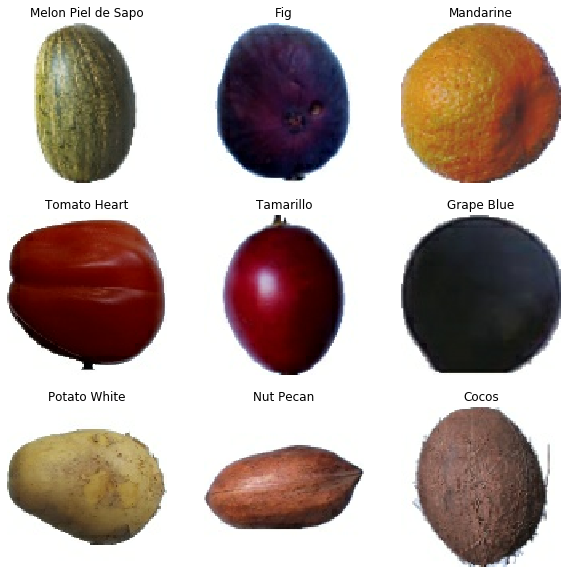

In [12]:
class_names = train_images.class_names

#Show a sample handful of images/classes
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
num_classes = len(class_names)

#Build a basic convnet model
model = models.Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(1, kernel_size = (3,3), padding='same'),
    layers.MaxPooling2D((2, 2)), #50x50
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss = losses.SparseCategoricalCrossentropy(),
    optimizer = optimizers.Adam(),
    metrics = ['sparse_categorical_accuracy']
)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 1)       28        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 1)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 131)               327631    
Total params: 327,659
Trainable params: 327,659
Non-trainable params: 0
_________________________________________________________________


In [23]:
results = model.fit(train_images, epochs=10)

Epoch 1/10
2116/2116 [==============================] - 77s 36ms/step - loss: 11.7986 - sparse_categorical_accuracy: 0.7136
Epoch 2/10
2116/2116 [==============================] - 69s 32ms/step - loss: 1.0301 - sparse_categorical_accuracy: 0.9185
Epoch 3/10
2116/2116 [==============================] - 67s 32ms/step - loss: 0.7432 - sparse_categorical_accuracy: 0.9401
Epoch 4/10
2116/2116 [==============================] - 66s 31ms/step - loss: 0.5534 - sparse_categorical_accuracy: 0.9571
Epoch 5/10
2116/2116 [==============================] - 66s 31ms/step - loss: 0.5278 - sparse_categorical_accuracy: 0.9642
Epoch 6/10
2116/2116 [==============================] - 67s 32ms/step - loss: 0.4137 - sparse_categorical_accuracy: 0.9731 2s - loss: 0.
Epoch 7/10
2116/2116 [==============================] - 67s 32ms/step - loss: 0.3782 - sparse_categorical_accuracy: 0.9775
Epoch 8/10
2116/2116 [==============================] - 68s 32ms/step - loss: 0.3602 - sparse_categorical_accuracy: 0.9807
E

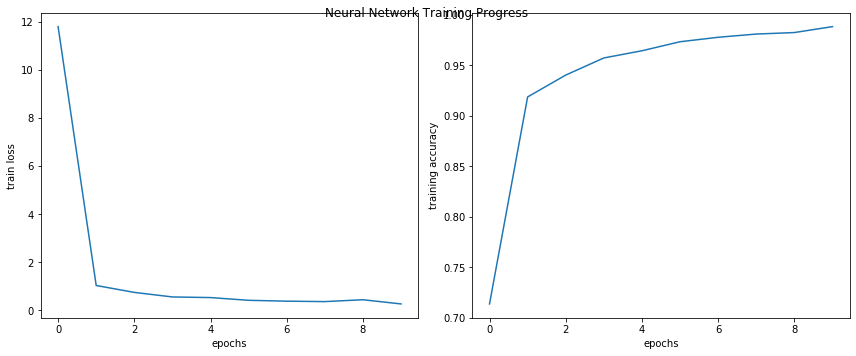

In [165]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.ylabel('train loss')
plt.xlabel('epochs')

plt.subplot(1, 2, 2)
plt.plot(results.history['sparse_categorical_accuracy'])
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.suptitle("Neural Network Training Progress \n")
plt.tight_layout()
plt.show()

### The training progress appears decent, so let's save our progress and evaluate the model on the test set

In [43]:
#model.save("basic_convnet_1")
model_evaluation = model.evaluate(test_images)

709/709 [==============================] - 10s 14ms/step - loss: 15.9186 - sparse_categorical_accuracy: 0.7569


### The test accuracy is quite poor in comparison to the training accuracy, suggesting a small case of overfitting - our model became accurate to the training data but couldn't generalize to the test data. Let's build another model with more filters in the conv2D layer and a larger pool size in the max pooling 2D layer to see if we can do better

In [30]:
#Build a basic convnet model
model2 = models.Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(filters=10, kernel_size = (3,3), padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=3), #33x33
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

model2.compile(
    loss = losses.SparseCategoricalCrossentropy(),
    optimizer = optimizers.Adam(),
    metrics = ['sparse_categorical_accuracy']
)

In [31]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 10)      280       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 33, 33, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 10890)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 131)               1426721   
Total params: 1,427,001
Trainable params: 1,427,001
Non-trainable params: 0
_________________________________________________________________


### This model should take a little longer to train per epoch due to many more trainable parameters and filters, so let's reduce the epochs from 10 to 5 for now and see if it's still worth it

In [32]:
results2 = model2.fit(train_images, epochs=5)

Epoch 1/5
2116/2116 [==============================] - 82s 39ms/step - loss: 19.3619 - sparse_categorical_accuracy: 0.8646
Epoch 2/5
2116/2116 [==============================] - 86s 40ms/step - loss: 4.2688 - sparse_categorical_accuracy: 0.9521
Epoch 3/5
2116/2116 [==============================] - 84s 40ms/step - loss: 3.2806 - sparse_categorical_accuracy: 0.9710
Epoch 4/5
2116/2116 [==============================] - 84s 40ms/step - loss: 3.1740 - sparse_categorical_accuracy: 0.9779
Epoch 5/5
2116/2116 [==============================] - 84s 40ms/step - loss: 2.8347 - sparse_categorical_accuracy: 0.9827


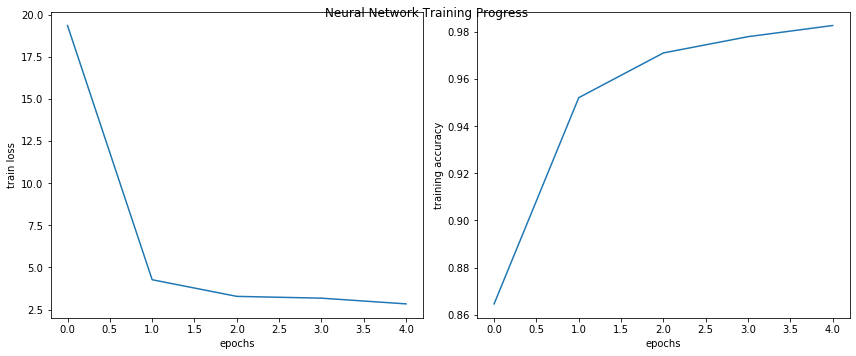

In [166]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(results2.history['loss'])
plt.ylabel('train loss')
plt.xlabel('epochs')

plt.subplot(1, 2, 2)
plt.plot(results2.history['sparse_categorical_accuracy'])
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.suptitle("Neural Network Training Progress \n")
plt.tight_layout()
plt.show()

### This looks better already, and it seems as though there would still be some room to grow with more epochs. Maybe we can circle back to this, but for now let's evaluate and continue forward to see if we find a better model we'd rather spend time training

In [42]:
#model2.save("basic_convnet_2")
model2_evaluation = model2.evaluate(test_images)

709/709 [==============================] - 12s 17ms/step - loss: 66.7420 - sparse_categorical_accuracy: 0.8611


### ~86.1% test accuracy is significantly better than the ~75.7% we got from our first model, but there are still some improvements I'd like to make! Adding a bit more depth will make the model once again train slightly slower due to more kernels being created, but we can significantly reduce our trainable parameters by doing so, which I'm hoping will lead to more intelligent feature extraction.

In [33]:
#Build a deeper convnet model
deeper_convnet = models.Sequential([
    layers.Input(shape=(100,100,3)),
    
    layers.Conv2D(filters=10, kernel_size = (3,3), padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=3), #33x33
    
    layers.Conv2D(filters=10, kernel_size = (3,3), padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=3), #33x33
    
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

deeper_convnet.compile(
    loss = losses.SparseCategoricalCrossentropy(),
    optimizer = optimizers.Adam(),
    metrics = ['sparse_categorical_accuracy']
)

In [34]:
deeper_convnet.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 10)      280       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 33, 33, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 33, 10)        910       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 10)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1210)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 131)               158641    
Total params: 159,831
Trainable params: 159,831
Non-trainable params: 0
________________________________________________

In [36]:
results_deeper = deeper_convnet.fit(train_images, epochs=5)

Epoch 1/5
2116/2116 [==============================] - 91s 43ms/step - loss: 3.1680 - sparse_categorical_accuracy: 0.8457
Epoch 2/5
2116/2116 [==============================] - 92s 43ms/step - loss: 0.3417 - sparse_categorical_accuracy: 0.9579
Epoch 3/5
2116/2116 [==============================] - 92s 43ms/step - loss: 0.2894 - sparse_categorical_accuracy: 0.9721
Epoch 4/5
2116/2116 [==============================] - 94s 44ms/step - loss: 0.2624 - sparse_categorical_accuracy: 0.9794
Epoch 5/5
2116/2116 [==============================] - 92s 43ms/step - loss: 0.2523 - sparse_categorical_accuracy: 0.9842


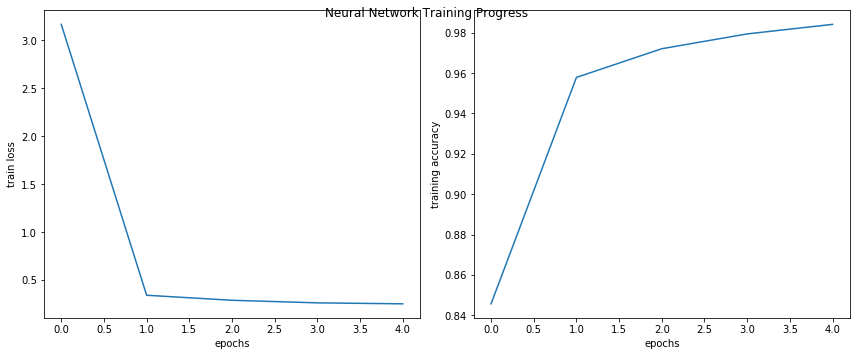

In [167]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(results_deeper.history['loss'])
plt.ylabel('train loss')
plt.xlabel('epochs')

plt.subplot(1, 2, 2)
plt.plot(results_deeper.history['sparse_categorical_accuracy'])
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.suptitle("Neural Network Training Progress \n")
plt.tight_layout()
plt.show()

In [37]:
#deeper_convnet.save("deeper_convnet_1")

INFO:tensorflow:Assets written to: deeper_convnet_1\assets


### The difference in train time was quite minimal, and resulted in what is actually a much smaller model (~160k trainable params compared to the 2nd basic model, which had over 1.4M trainable params). Inference should be comparable or more efficient with this model, and the deeper model is less susceptible to over-fitting since it is getting similar results with less trainable parameters.

In [41]:
deeper_evaluation = deeper_convnet.evaluate(test_images)

709/709 [==============================] - 13s 18ms/step - loss: 5.8889 - sparse_categorical_accuracy: 0.8493


### ~85% test accuracy is about 1% less than the previous, less deep model but let's check how they compare on the Google images that are unrelated to the original dataset

### First, the second model (less deep)

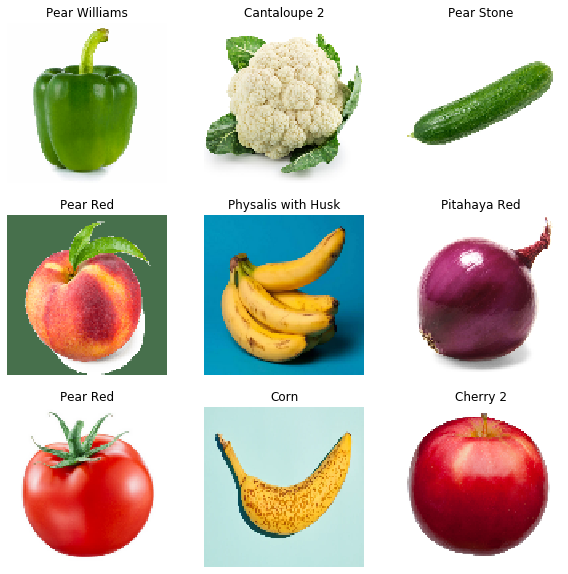

In [198]:
#Show a sample handful of images/predictions
plt.figure(figsize=(10, 10))
for images in test_images_google.take(1):
    predictions = model2.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predictions[i].argmax()])
        plt.axis("off")

### Unfortunately, this model that performed quite well in the test set is actually quite pitiful when it comes to data from the real world - some things are at least close such as the red apple being labeled a cherry, but it thinks cauliflower is a cantaloupe and that's a little embarrassing.
### Let's see how the deeper model compares

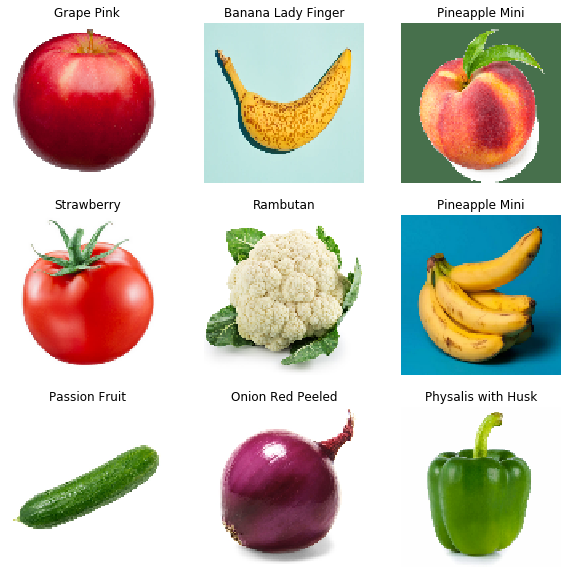

In [199]:
#Show a sample handful of images/predictions
plt.figure(figsize=(10, 10))
for images in test_images_google.take(1):
    deeper_predictions = deeper_convnet.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[deeper_predictions[i].argmax()])
        plt.axis("off")

### Interesting... the deeper convnet doesn't perform terrificly on data that isn't part of the original dataset either, but predicting 2/9 correctly is certainly an improvement over 0/9. Obviously this is with a very small sample size but it does at least somewhat show a more intelligent set of predictions. Let's move forward for now and try some transfer learning models to see how they perform.

## Transfer Learning
### First, we'll start with Google's InceptionV3 model

In [58]:
inception_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

87924736/87910968 [==============================] - 13s 0us/step


In [59]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_386 (Conv2D)             (None, 49, 49, 32)   864         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 49, 49, 32)   96          conv2d_386[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 49, 49, 32)   0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

### We'll make sure that the layers aren't trainable and then add a couple layers to the end and change the output to match our models

In [65]:
inception_model.trainable = False

transfer_model = models.Sequential([
    inception_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

transfer_model.compile(
    loss = losses.SparseCategoricalCrossentropy(),
    optimizer = optimizers.Adam(),
    metrics = ['sparse_categorical_accuracy']
)

In [66]:
transfer_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 131)               268419    
Total params: 22,071,203
Trainable params: 268,419
Non-trainable params: 21,802,784
_________________________________________________________________


In [67]:
transfer_model_results = transfer_model.fit(train_images, epochs=5)

Epoch 1/5
2116/2116 [==============================] - 285s 134ms/step - loss: 39.6435 - sparse_categorical_accuracy: 0.5033
Epoch 2/5
2116/2116 [==============================] - 293s 139ms/step - loss: 18.9085 - sparse_categorical_accuracy: 0.7051
Epoch 3/5
2116/2116 [==============================] - 298s 141ms/step - loss: 16.9615 - sparse_categorical_accuracy: 0.7554
Epoch 4/5
2116/2116 [==============================] - 291s 137ms/step - loss: 15.7791 - sparse_categorical_accuracy: 0.7848
Epoch 5/5
2116/2116 [==============================] - 277s 131ms/step - loss: 14.9166 - sparse_categorical_accuracy: 0.8035


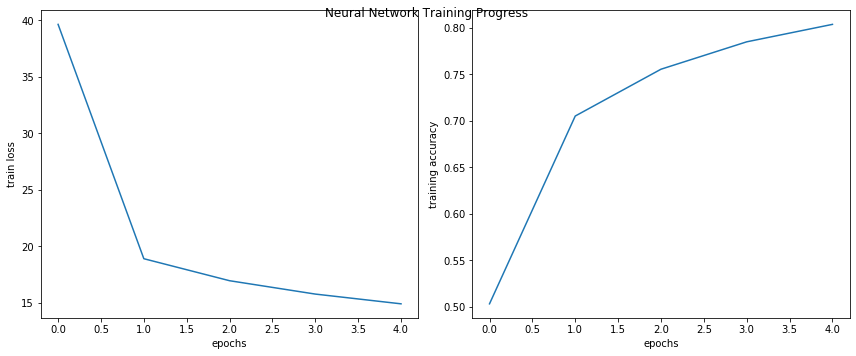

In [170]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(transfer_model_results.history['loss'])
plt.ylabel('train loss')
plt.xlabel('epochs')

plt.subplot(1, 2, 2)
plt.plot(transfer_model_results.history['sparse_categorical_accuracy'])
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.suptitle("Neural Network Training Progress \n")
plt.tight_layout()
plt.show()

In [68]:
transfer_evaluation = transfer_model.evaluate(test_images)

709/709 [==============================] - 105s 146ms/step - loss: 40.8549 - sparse_categorical_accuracy: 0.7057


### It looks like there's still a fair bit of room for this model to grow, as the accuracy slope is still quite steep. It is worth noting however that the epochs for this took significantly longer than our previous models at over 3x the time per epoch (as expected due to the model being much larger). For this reason, I think we should aim higher before we train a model like this for any longer. Let's make another transfer model using InceptionV3 but with a GlobalAveragePooling2D layer instead of the MaxPooling2D and Dropout layers we had before.

In [73]:
transfer_model2 = models.Sequential([
    inception_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

transfer_model2.compile(
    loss = losses.SparseCategoricalCrossentropy(),
    optimizer = optimizers.Adam(),
    metrics = ['sparse_categorical_accuracy']
)

In [74]:
transfer_model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 131)               268419    
Total params: 22,071,203
Trainable params: 268,419
Non-trainable params: 21,802,784
_________________________________________________________________


In [75]:
transfer_model2_results = transfer_model2.fit(train_images, epochs=5)

Epoch 1/5
2116/2116 [==============================] - 297s 139ms/step - loss: 13.3011 - sparse_categorical_accuracy: 0.6833
Epoch 2/5
2116/2116 [==============================] - 298s 141ms/step - loss: 5.7952 - sparse_categorical_accuracy: 0.8588
Epoch 3/5
2116/2116 [==============================] - 309s 146ms/step - loss: 4.4319 - sparse_categorical_accuracy: 0.9023
Epoch 4/5
2116/2116 [==============================] - 305s 144ms/step - loss: 3.6797 - sparse_categorical_accuracy: 0.9242
Epoch 5/5
2116/2116 [==============================] - 323s 153ms/step - loss: 3.1467 - sparse_categorical_accuracy: 0.9382


### So far, this looks significantly better than our first attempt at a transfer model and took a similar amount of time. Let's save our results and evaluate the model.

In [171]:
#transfer_model2.save("transfer_model2_trained")

In [172]:
transfer2_evaluation = transfer_model2.evaluate(test_images)

709/709 [==============================] - 126s 177ms/step - loss: 30.9133 - sparse_categorical_accuracy: 0.7402


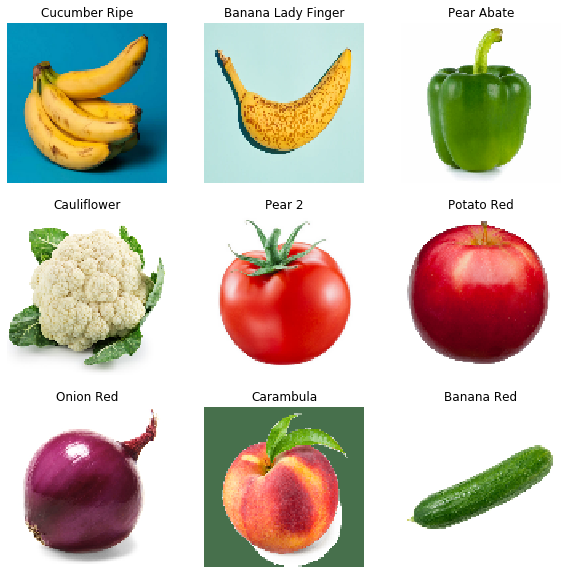

In [201]:
#Show a sample handful of images/predictions
plt.figure(figsize=(10, 10))
for images in test_images_google.take(1):
    transfer_predictions = transfer_model2.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[transfer_predictions[i].argmax()])
        plt.axis("off")

### Another marginal improvement in the real-world images -- despite having a lower test accuracy (~74% compared to ~85% from the deeper convnet), the InceptionV3 transfer model predicted 3/9 of the Google images correctly, and was quite close on some of the others such as mistaking the red apple for a red potato.

In [122]:
#transfer_model2 = models.load_model("transfer_model2_trained")

### Now let's try using Oxford's VGG16 model for transfer learning. This one is much larger than InceptionV3 so it may take a little longer to train.

In [126]:
vgg16_base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

58900480/58889256 [==============================] - 9s 0us/step


### As before, we'll ensure that the base model is no longer trainable and add a new layer just before the output layer to gain some trainable parameters.

In [128]:
vgg16_base_model.trainable = False

transfer_vgg = models.Sequential([
    vgg16_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

transfer_vgg.compile(
    loss = losses.SparseCategoricalCrossentropy(),
    optimizer = optimizers.Adam(),
    metrics = ['sparse_categorical_accuracy']
)

In [129]:
transfer_vgg.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 131)               67203     
Total params: 14,781,891
Trainable params: 67,203
Non-trainable params: 14,714,688
_________________________________________________________________


In [133]:
transfer_vgg_results = transfer_vgg.fit(train_images, epochs=5)

Epoch 1/5
2116/2116 [==============================] - 1926s 910ms/step - loss: 0.3098 - sparse_categorical_accuracy: 0.9344
Epoch 2/5
2116/2116 [==============================] - 1894s 895ms/step - loss: 0.0338 - sparse_categorical_accuracy: 0.9913
Epoch 3/5
2116/2116 [==============================] - 1895s 896ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9928
Epoch 4/5
2116/2116 [==============================] - 1895s 896ms/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9939
Epoch 5/5
2116/2116 [==============================] - 1911s 903ms/step - loss: 0.0077 - sparse_categorical_accuracy: 0.9983


### This took a lot longer than I expected, and I actually ended up running it overnight. The training accuracy looks incredibly promising at almost 100%. Let's save this and see how it performs on the test set.

In [136]:
#transfer_vgg.save("transfer_vgg_trained")

INFO:tensorflow:Assets written to: transfer_vgg_trained\assets


In [134]:
transfer_vgg_evaluation = transfer_vgg.evaluate(test_images)

709/709 [==============================] - 660s 931ms/step - loss: 0.9611 - sparse_categorical_accuracy: 0.9045


### >90% test accuracy is our best so far. Let's check how it performs on the hand-selected Google images.

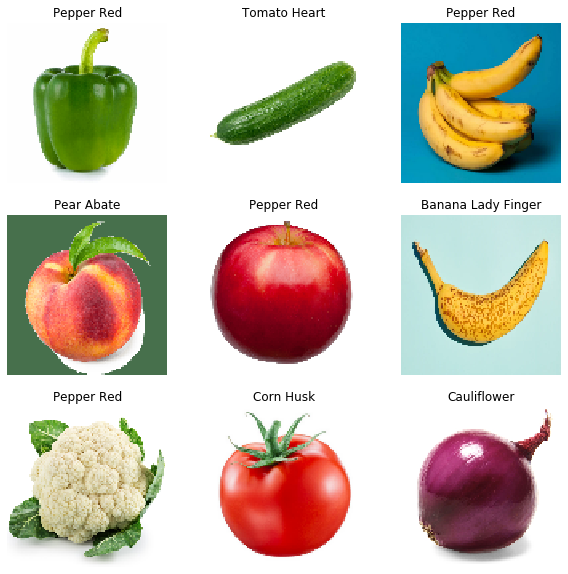

In [202]:
#Show a sample handful of images/predictions
plt.figure(figsize=(10, 10))
for images in test_images_google.take(1):
    transfer_vgg_predictions = transfer_vgg.predict(test_images_google)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[transfer_vgg_predictions[i].argmax()])
        plt.axis("off")